## Exploratory

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [4]:
stop_words = set(stopwords.words('english')) # Make stopword list

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (2,2), stop_words=stop_words).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list[:7]

In [5]:
def restaurant_list(df, restaurant=None, neighborhood=None, type_rest=None, price=None):

    if restaurant != None:
        df = df[df['restaurant_name'].isin(['restaurant'])]
        return restaurant

    if neighborhood != None:
        df = df[df['neighborhood'].isin(neighborhood)]
    
    if type_rest != None:
        df = df[df['type'].isin(type_rest)]
    
    if price != None:
        df = df[df['price'].isin(price)]

    if df.shape[0] == 0:
        return "No restaurants found."
        
    else:
        restaurant = list(df['restaurant_name'].unique())
        
    return restaurant

In [6]:
def review_scatter(df, restaurant, title):
    df = df[df['restaurant_name'].isin(restaurant)]
    data = df.groupby('monthyear').agg({'comment_dates':'mean','comment_ratings':'mean','review_count':'count', 'comment_trans':transform_create_list})
    data = data.rename(columns={'comment_dates':'Dates','comment_ratings':'Ratings','review_count':'#Comments','comment_trans':'Tfidf'})
    data['Tfidf'] = [i for i in data['Tfidf']]
    #x = data.Dates.values
    data.sort_values('Dates',inplace = True)
    #y = data.Ratings.values
    plt.figure(figsize=(20,10))
    f=sns.scatterplot(data = data,x='Dates', y='Ratings', hue='Ratings', size='#Comments', palette='coolwarm_r', sizes=(100, 1000))
    #for i in data.index:
        #f.annotate(data['Tfidf'].loc[i][0][0], (data['Dates'].loc[i], data['Ratings'].loc[i]), size=10)
    f.get_legend().remove()
    #plt.legend(labels=[i for i in data['#Comments']], bbox_to_anchor=(1, 1), scatterpoints=1, markerscale=0.8, borderpad=2, labelspacing=2)
    plt.title(f'{title}    ({len(restaurant)} restaurants   -   {df.shape[0]} reviews)', loc='left')
    plt.show();

In [119]:
def review_barplot(df, restaurant, title):

    df = df[df['restaurant_name'].isin(restaurant)]
    data = df.groupby('monthyear').agg({'comment_dates':'mean','comment_ratings':'mean','review_count':'count', 'comment_trans':transform_create_list})
    data = data.rename(columns={'comment_dates':'Dates','comment_ratings':'Ratings','review_count':'#Comments','comment_trans':'Tfidf'})
    data['Tfidf'] = [i for i in data['Tfidf']]
    plt.figure(figsize=(20,10))
    data.sort_values(by='Dates', inplace=True)
    f=sns.barplot(data=data, x='Dates', y='#Comments', color='#ec645c', edgecolor='black')
    
    for k, v in enumerate(data['Tfidf']):
        f.text(k, data['#Comments'].values[k], ',\n'.join([i[0] for i in v[:3]]), ha='center', color='black', size=9, bbox={'facecolor': '#f58eaf', 'alpha': 1, 'pad': 10})
        if data['#Comments'].values[k] > max(data['#Comments'].values)*0.1:
            f.text(k, 1, data['#Comments'].values[k], va='bottom', ha='center', color='black', size=14, weight='bold', fontname="Arial")

    f2 = f.twinx()
    f2.plot(data['Ratings'].values, linestyle='-', linewidth=2, color='#f4c46c', marker='o', markerfacecolor='#f4c46c', markeredgecolor='black', markersize=30, markeredgewidth=0.5, label='Rating')
    for k, v in enumerate(data['Ratings']):
        f2.text(k, data['Ratings'].values[k]-0.04, round(v,1), color='black', ha='center', size=12, weight='bold', fontname="Arial")
    
    
    f.spines["right"].set_visible(False)
    f.spines["left"].set_visible(False)
    f.spines["top"].set_visible(False)

    f2.spines["left"].set_visible(False)
    f2.spines["top"].set_visible(False)
    f2.spines["right"].set_visible(False)

    
    f2.set_ylim(0,6)
    
    f.set_yticks([])
    f2.set_yticks([])
    
    labels = [i.year for i in data.Dates]
    f.set_xticklabels(labels, size=15, fontname="Arial")
    
    f.set_xlabel('')
    f.set_ylabel('')
    
    plt.title(f'{title}    ({len(restaurant)} restaurants   -   {df.shape[0]} reviews)', loc='left', size=15, fontname="Arial")
    
    legend_elements = [Line2D([0], [0], linestyle='-', linewidth=2, color='#f4c46c', marker='o', markerfacecolor='#f4c46c', markeredgecolor='black', markersize=10, markeredgewidth=0.5, label='Ratings'),
                       Patch(facecolor='#f58eaf', label='Number of reviews'),
                       Patch(facecolor='#ec645c', edgecolor='black', label='Frequent topics')]
    
    f.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=3, fontsize=15, edgecolor='white')
    
    plt.show();

In [120]:
def restaurant_full_analysis(df, restaurant=None, neighborhood=None, type_rest=None, price=None):
    
    df = df.copy()
    df['comment_dates'] = pd.to_datetime(df['comment_dates'])
    df['monthyear'] = df['comment_dates'].map(lambda x : int(f'{x.year}'))

    if restaurant != None:
        title = restaurant
    else:
        title = (f'Neighborhoods : {neighborhood}   -   Categories : {type_rest}   -   Price ranges : {price}')

    restaurant = restaurant_list(df, restaurant, neighborhood, type_rest, price)

    #review_scatter(df, restaurant, title)
    review_barplot(df, restaurant, title)

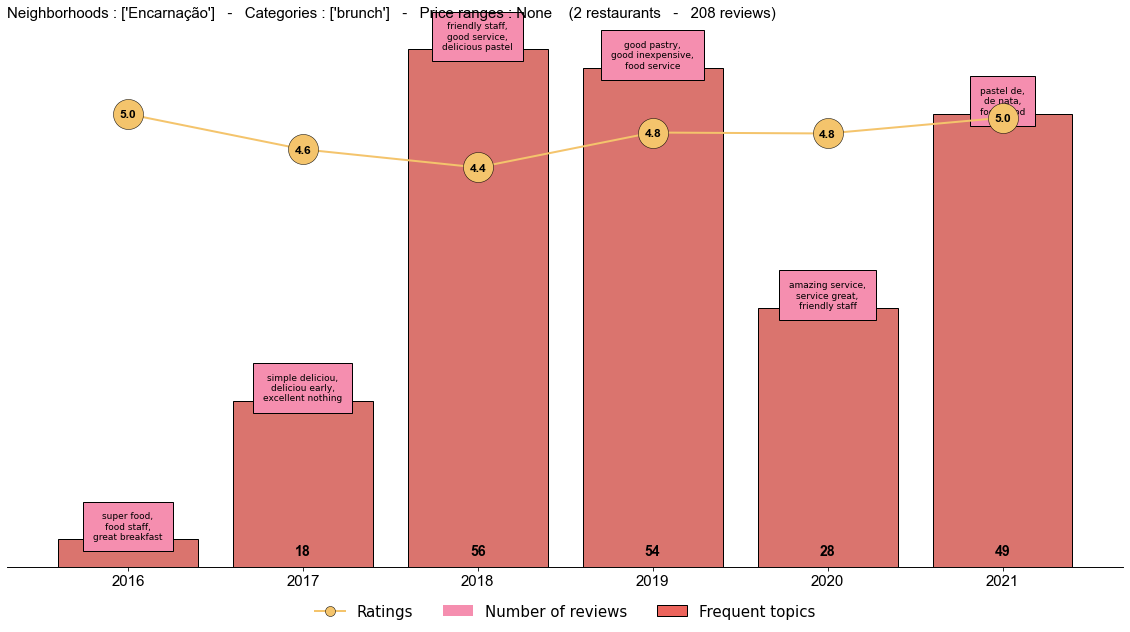

In [121]:
reviews = pd.read_csv('../../small_business/data/reviews.csv')

restaurant = None
neighborhood = None
type_rest = None
price = None

# either this
#restaurant = ['Flor da Laranja']

# or this
neighborhood = ['Encarnação']
type_rest = ['brunch']
#price = [1]

restaurant_full_analysis(reviews, restaurant=restaurant, neighborhood=neighborhood, type_rest=type_rest, price=price)